In [1]:
import io
import os
from datetime import datetime
import time
import random
import numpy as np
import glob
import sklearn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# import tikzplotlib
import wiggle
import PIL
import json
import imageio
import pydot
import graphviz
import h5py
from pathlib import Path



plt.rcParams['figure.figsize'] = [15, 2]

import random
from scipy import signal
from scipy.sparse import random
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import mixed_precision

tf.config.optimizer.set_jit(True)
tfk = tf.keras
tfkl = tf.keras.layers
tfkltd= tf.keras.layers.TimeDistributed

import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"

gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

print(tf.__version__)

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import gc
plt.style.use("ggplot")


def report(model, name):
    model.summary(line_length=150)

2022-07-25 15:20:46.779532: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  1
2.9.1


In [2]:
nt=800

In [3]:
def conv_with_path(s, nsamp, nt, style='spike'):
    d=np.zeros((nsamp,nt))
    pp=np.zeros((nsamp, nt))
    
    
    for i in range(nsamp):
            if style=='spike':
                p=np.zeros((nt))
                p[np.random.randint(200,600)]=np.random.choice((-1, 1))
                # p[np.random.randint(200,600)]=-0.75
                # p[np.random.randint(200,600)]=0.75
                # p[np.random.randint(200,600)]=-0.8
                # np.random.randn() 
            else:
                p=np.array(random(nt, 1, density=0.05).A)[:,0]
                p[0:200] = 0.0
                p[600:nt] = 0.0
                # p[200:600] = np.random.randn(400)
            pp[i, :]=p
            d1=signal.convolve(p,s,'same') #convolution(source*path)
            d[i,:]=d1/np.std(d1) #normailised data
    return d, pp

In [4]:
nsamp=1000
dsyn1=np.zeros((nsamp,nt))
dsyn2=np.zeros((nsamp,nt))

# S1=np.random.randn(np.random.randint(100,200)) #define random source
# window=signal.ricker(100, 10)
# s1 = np.convolve(window, S1, mode='valid')
s1=np.diff(signal.windows.bartlett(51))
s1=signal.windows.bartlett(51)
# s1=signal.windows.cosine(51)

# S2=np.random.randn(np.random.randint(100,200)) #define random source
# window=signal.ricker(200, 10)
# s2 = np.convolve(window, S2, mode='valid')
s2=window=signal.ricker(200, 10)
# s2=window=signal.boxcar(80)

dsyn1, p1=conv_with_path(s1, nsamp, nt)
dsyn2, p2=conv_with_path(s2, nsamp, nt)

# s3=signal.windows.bartlett(51)
s3 = np.diff(signal.windows.bartlett(51))
s3 = [1.,0]
dsyn_mix_half1, pmix_half1=conv_with_path(s1, nsamp//2, nt)
dsyn_mix_half2, pmix_half2=conv_with_path(s2, nsamp//2, nt)

dsyn_mix=np.concatenate([dsyn_mix_half1, dsyn_mix_half2])
pmix=np.concatenate([pmix_half1, pmix_half2])

# dsyn_mix, pmix = conv_with_path(s3, nsamp, nt, 'spike')
dsyn1_test, p1test=conv_with_path(s1, 100, nt)
dsyn2_test, p2test=conv_with_path(s2, 100, nt)
dsyn_mix_test, pmixtest = conv_with_path([1, 0], 100, nt, 'spike')



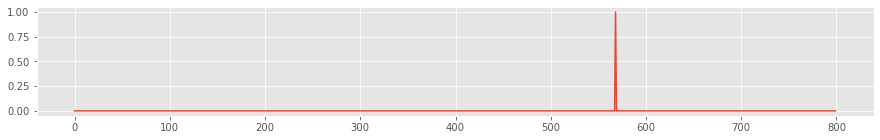

In [5]:
plt.plot(p1[0])

In [6]:
# plt.plot(p)
# np.random.choice([s1, s2]).shape
dsyn_mix.shape

(1000, 800)

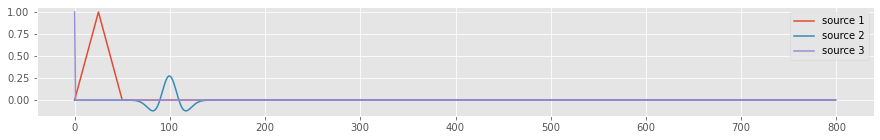

In [7]:
plt.plot(np.pad(s1, (0,nt-len(s1))), label='source 1')
plt.plot(np.pad(s2, (0,nt-len(s2))), label='source 2')
plt.plot(np.pad(s3, (0,nt-len(s3))), label='source 3')
plt.legend()

In [8]:
train_data=[]
train_data.append(dsyn1)
train_data.append(dsyn2)
# train_data.append(dsyn_mix)
test_data=[]
test_data.append(dsyn1_test)
test_data.append(dsyn2_test)
# test_data.append(dsyn_mix_test)
len(train_data)

2

762


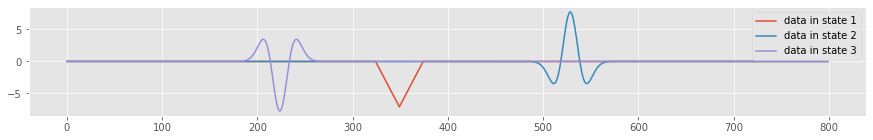

In [9]:
i=np.random.randint(0,nsamp)
plt.plot(dsyn1[i,:], label='data in state 1');
plt.plot(dsyn2[i,:], label='data in state 2');
plt.plot(dsyn_mix[i,:], label='data in state 3');
plt.legend()
print(i)

In [10]:
batch_size=8
ninstance=20

weights_train=np.array([ds.shape[0] for ds in train_data]).astype(np.float32)
Xo_train=tf.data.Dataset.sample_from_datasets([tf.data.Dataset.from_tensor_slices((ds.astype(np.float32), ds.astype(np.float32))).repeat().shuffle(500).batch(ninstance, drop_remainder=True) for ds in train_data], weights=weights_train).repeat().batch(batch_size)
# Xo_train=tf.data.Dataset.sample_from_datasets([tf.data.Dataset.from_tensor_slices((ds.astype(np.float32), ds.astype(np.float32))).repeat().shuffle(2000).batch(ninstance, drop_remainder=True) for ds in train_data]).repeat().batch(batch_size)
print(Xo_train.element_spec)
Xo_train = Xo_train.prefetch(tf.data.experimental.AUTOTUNE)

Xo_perf=tf.data.Dataset.sample_from_datasets([tf.data.Dataset.from_tensor_slices((ds.astype(np.float32), ds.astype(np.float32))).repeat().batch(ninstance, drop_remainder=True) for ds in train_data], weights=weights_train).repeat().batch(batch_size)



Xo_test=tf.data.Dataset.sample_from_datasets([tf.data.Dataset.from_tensor_slices((ds.astype(np.float32), ds.astype(np.float32))).repeat().shuffle(ninstance).batch(ninstance, drop_remainder=True) for ds in test_data]).repeat().batch(batch_size)
print(Xo_test.element_spec)
Xo_test = Xo_test.prefetch(tf.data.experimental.AUTOTUNE)

(TensorSpec(shape=(None, 20, 800), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20, 800), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 20, 800), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20, 800), dtype=tf.float32, name=None))


2022-07-25 15:20:55.648254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-25 15:20:56.261018: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13931 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:89:00.0, compute capability: 8.6


In [11]:

# run for nzi in 
class SymAE(tf.keras.Model):
  def __init__(self, nt, nz0, nzi, ninstance):
    super(SymAE, self).__init__()
    self.symencoder=tfk.Sequential()
    self.symencoder.add(tfkl.Dense(700,activation='elu'))
    self.symencoder.add(tfkl.Dense(500,activation='elu'))
    self.symencoder.add(tfkl.Lambda(lambda x: tf.math.reduce_mean(x, axis=1)))
    self.symencoder.add(tfkl.Dense(400,activation='elu'))
    self.symencoder.add(tfkl.BatchNormalization())
    self.symencoder.add(tfkl.Dense(nz0))
    

    self.nencoder=tfk.Sequential()
    self.nencoder.add(tfkl.Dense(700,activation='elu'))
    self.nencoder.add(tfkl.Dense(500,activation='elu'))
    self.nencoder.add(tfkl.Dense(400,activation='elu'))
    self.symencoder.add(tfkl.BatchNormalization())
    self.nencoder.add(tfkl.Dense(nzi))
    self.drop=tfkl.Dropout(0.5)
    
    self.decoder=tfk.Sequential()
    self.decoder.add(tfkl.Dense(300,activation='elu'))
    self.decoder.add(tfkl.Dense(400,activation='elu'))
    self.decoder.add(tfkl.Dense(600,activation='elu'))
    self.decoder.add(tfkl.Dense(nt))

    self.repeatzsym=tfk.Sequential()
    self.repeatzsym.add(tfkl.RepeatVector(ninstance))

  def call(self, input_tensor, training=False):
    zsym=self.symencoder(input_tensor)
    zsymr=self.repeatzsym(zsym)

    zn=self.nencoder(input_tensor)
    zn=self.drop(zn, training=training)
    
    lcode=tfkl.concatenate([zsymr, zn], axis=2)
    xhat = self.decoder(lcode)
    return xhat

In [12]:

class SymAEconv(tf.keras.Model):
  def __init__(self, nt, nz0, nzi, ninstance, k1=10):
    super(SymAEconv, self).__init__()
    self.symencoder=tfk.Sequential()
    self.symencoder.add(tfkltd(tfkl.Reshape(target_shape=(-1,1))))
    self.symencoder.add(tfkltd(tfkl.Conv1D(64,(k1),padding='same',activation='elu')))
    self.symencoder.add(tfkltd(tfkl.Conv1D(64,(k1),padding='same',activation='elu')))
    self.symencoder.add(tfkltd(tfkl.MaxPool1D(pool_size=(2))))
    self.symencoder.add(tfkltd(tfkl.Conv1D(64,(k1),padding='same',activation='elu')))
    self.symencoder.add(tfkltd(tfkl.Conv1D(64,(k1),padding='same',activation='elu')))
    self.symencoder.add(tfkltd(tfkl.MaxPool1D(pool_size=(2))))
    self.symencoder.add(tfkl.Lambda(lambda x: tf.math.reduce_mean(x, axis=1)))


    self.symencoder.add(tfkl.Conv1D(32,(k1),padding='same',activation='elu'))
    self.symencoder.add(tfkl.MaxPool1D(pool_size=(2)))
    self.symencoder.add(tfkl.Conv1D(1,(k1),padding='same',activation='elu'))
    self.symencoder.add(tfkl.BatchNormalization())
    self.symencoder.add(tfkl.Activation('elu'))
    self.symencoder.add(tfkl.MaxPool1D(pool_size=(4)))
    self.symencoder.add(tfkl.Flatten())
    self.symencoder.add(tfkl.Dense(nz0))

    

    self.nencoder=tfk.Sequential()
    self.nencoder.add(tfkltd(tfkl.Reshape(target_shape=(-1,1))))
    self.nencoder.add(tfkltd(tfkl.Conv1D(64,(k1),padding='same',activation='elu')))
    self.nencoder.add(tfkltd(tfkl.Conv1D(64,(k1),padding='same',activation='elu')))
    self.nencoder.add(tfkltd(tfkl.MaxPool1D(pool_size=(2))))
    self.nencoder.add(tfkltd(tfkl.Conv1D(64,(k1),padding='same',activation='elu')))
    self.nencoder.add(tfkltd(tfkl.Conv1D(32,(k1),padding='same',activation='elu')))
    self.nencoder.add(tfkltd(tfkl.MaxPool1D(pool_size=(2))))
    self.nencoder.add(tfkltd(tfkl.Conv1D(32,(k1),padding='same',activation='elu')))
    self.nencoder.add(tfkltd(tfkl.Conv1D(32,(k1),padding='same',activation='elu')))
    self.nencoder.add(tfkltd(tfkl.MaxPool1D(pool_size=(2))))
    self.nencoder.add(tfkltd(tfkl.Conv1D(8,(k1),padding='same',activation='elu')))
    self.nencoder.add(tfkltd(tfkl.Conv1D(1,(k1),padding='same')))
    self.nencoder.add(tfkltd(tfkl.BatchNormalization()))
    self.nencoder.add(tfkltd(tfkl.Activation('elu')))
    self.nencoder.add(tfkltd(tfkl.MaxPool1D(pool_size=(2))))
    self.nencoder.add(tfkltd(tfkl.Flatten()))
    self.nencoder.add(tfkltd(tfkl.Dense(nzi)))

    self.drop=tfkl.Dropout(0.8)

    self.decoder=tfk.Sequential()

    self.decoder.add(tfkltd(tfkl.Dense(units=((nt//2)*1),activation='elu')))
    self.decoder.add(tfkltd(tfkl.Reshape(target_shape=(-1,1))))
    self.decoder.add(tfkltd(tfkl.Conv1D(64,(k1),padding='same',activation='elu')))
    self.decoder.add(tfkltd(tfkl.UpSampling1D(size=(2))))
    self.decoder.add(tfkltd(tfkl.Conv1D(64,(k1),padding='same',activation='elu')))
    self.decoder.add(tfkltd(tfkl.Conv1D(64,(k1),padding='same')))
    self.decoder.add(tfkltd(tfkl.BatchNormalization()))
    self.decoder.add(tfkltd(tfkl.Activation('elu')))
    self.decoder.add(tfkltd(tfkl.Conv1D(64,(k1),padding='same',activation='elu')))
    self.decoder.add(tfkltd(tfkl.Conv1D(64,(k1),padding='same',activation='elu')))
    self.decoder.add(tfkltd(tfkl.Conv1D(1,(k1),padding='same')))
    self.decoder.add(tfkl.Lambda(lambda x: tf.squeeze(x, axis=3)))

    self.repeatzsym=tfk.Sequential()
    self.repeatzsym.add(tfkl.RepeatVector(ninstance))


  def call(self, input_tensor, training=False):
    zsym=self.symencoder(input_tensor)
    zsymr=self.repeatzsym(zsym)

    zn=self.nencoder(input_tensor)
    zn=self.drop(zn, training=training)
    
    lcode=tfkl.concatenate([zsymr, zn], axis=2)
    xhat = self.decoder(lcode)
    return xhat

  def model(self, x):
    return tfk.Model(inputs=x, outputs=self.call(x))

* First mute the dropout, then try to estimate q such that we have reasolnable data reconsturction
* Then trun dropout on with alpha as 0.5 and the new q is 2* q_old 


In [13]:
# nzi=600
nzi=15

nz0=10
# model=SymAE(nt, nz0, nzi, ninstance)
model=SymAEconv(nt, nz0, nzi, ninstance)
model.symencoder.build((None,None,nt))
model.nencoder.build((None,None,nt))
model.decoder.build((None,None,nz0+nzi))
model.symencoder.summary()
model.nencoder.summary()
model.decoder.summary()
model.compile(optimizer='adam', loss='mse')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 800, 1)     0         
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 800, 64)    704       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 800, 64)    41024     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 400, 64)    0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 400, 64)    4

In [14]:
nepoch=1000
history=model.fit(Xo_train, epochs=nepoch, validation_data=Xo_test, steps_per_epoch=200, validation_steps=1)

Epoch 1/1000


2022-07-25 15:20:57.514592: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1750] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).
2022-07-25 15:21:01.425072: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7f036401a8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-07-25 15:21:01.425124: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2022-07-25 15:21:01.442697: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var

  3/200 [..............................] - ETA: 13s - loss: 2.3136  

2022-07-25 15:21:27.683954: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


200/200 [==============================] - ETA: 0s - loss: 0.9806

2022-07-25 15:21:41.247375: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


200/200 [==============================] - 44s 70ms/step - loss: 0.9806 - val_loss: 0.9229
Epoch 2/1000
  2/200 [..............................] - ETA: 12s - loss: 0.8335

2022-07-25 15:21:41.710552: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


200/200 [==============================] - 12s 61ms/step - loss: 0.8030 - val_loss: 0.6018
Epoch 3/1000
200/200 [==============================] - 12s 61ms/step - loss: 0.7407 - val_loss: 0.6414
Epoch 4/1000
200/200 [==============================] - 12s 61ms/step - loss: 0.7238 - val_loss: 0.6224
Epoch 5/1000
200/200 [==============================] - 12s 61ms/step - loss: 0.6993 - val_loss: 0.4128
Epoch 6/1000
200/200 [==============================] - 12s 61ms/step - loss: 0.6898 - val_loss: 0.7032
Epoch 7/1000
200/200 [==============================] - 12s 61ms/step - loss: 0.6718 - val_loss: 0.4378
Epoch 8/1000
200/200 [==============================] - 12s 61ms/step - loss: 0.6680 - val_loss: 0.4582
Epoch 9/1000
200/200 [==============================] - 12s 61ms/step - loss: 0.6410 - val_loss: 0.6468
Epoch 10/1000
 15/200 [=>............................] - ETA: 11s - loss: 0.6159

KeyboardInterrupt: 

NameError: name 'z0mix' is not defined

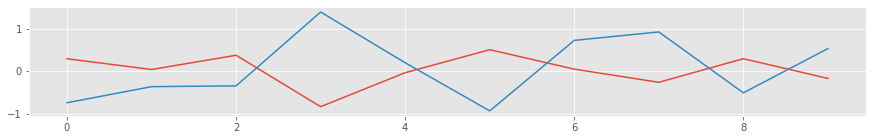

In [16]:
# z01=model.symencoder.predict(np.array([dsyn1,]), batch_size=1)
z01=model.symencoder(np.array([dsyn1,]))
z02=model.symencoder(np.array([dsyn2,]))
# z0mix=model.symencoder(np.array([dsyn_mix,]))
plt.plot(z01[0])
plt.plot(z02[0])
plt.plot(z0mix[0])

In [17]:
def fuse(z, W):
    Grepeat = np.array([np.repeat(z, W.shape[1], axis=0)])
    Z = np.concatenate((Grepeat, W), axis=2)
    return model.decoder(Z)[0].numpy()
    

In [18]:
W1=model.nencoder(np.array([dsyn1]));
W2=model.nencoder(np.array([dsyn2]));
# Wmix=model.nencoder(dsyn_mix);

In [19]:
# check reconstruction
dsyn1hat = fuse(z01, W1)
dsyn2hat = fuse(z02, W2)
# dsynmixhat = fuse(z0mix, Wmix)

In [20]:
# virtual; redatum source 2 to state 1
dsyn21=signal.convolve(p1,s2.reshape(1,-1),'same') #convolution(source*path)
dsyn21=dsyn21/np.std(dsyn21, axis=1, keepdims=True) #normailised data
dsyn21hat = fuse(z02, W1)

dsyn21hat=dsyn21hat/np.std(dsyn21hat, axis=1, keepdims=True) #normailised data

# dsyn1mixhat = fuse(z0mix, W1)

In [21]:
dsyn12hat = fuse(z01, W2)
dsyn12=signal.convolve(p2,s1.reshape(1,-1),'same') #convolution(source*path)
dsyn12=dsyn12/np.std(dsyn12, axis=1, keepdims=True) #normailised data
dsyn12hat=dsyn12hat/np.std(dsyn12hat, axis=1, keepdims=True) #normailised data

# dsyn2mixhat = fuse(z0mix, W2)

In [22]:

# # virtual; redatum sources 1 and 2 to state 3
# Grepeat = np.repeat(z01, len(Wmix), axis=0)
# Z = np.concatenate((Grepeat, Wmix), axis=1)
# dsyn1mixhat = model.decoder(Z)  # virtual trace

# Grepeat = np.repeat(z02, len(Wmix), axis=0)
# Z = np.concatenate((Grepeat, Wmix), axis=1)
# dsyn2mixhat = model.decoder(Z)  # virtual trace

In [23]:
dsyn21hat.shape

(1000, 800)

In [24]:
# redatuming mse

mse = tf.keras.losses.MeanSquaredError()
print(mse(dsyn12, dsyn12hat).numpy(), mse(dsyn21, dsyn21hat).numpy())

1.4834883 1.4488984


In [25]:
# redatuming mse
print(mse(dsyn12, dsyn12hat).numpy(), mse(dsyn21, dsyn21hat).numpy())

1.4834883 1.4488984


In [26]:
# redatuming mse
print(mse(dsyn12, dsyn12hat).numpy(), mse(dsyn21, dsyn21hat).numpy())

1.4834883 1.4488984


In [27]:
i=np.random.randint(nsamp)

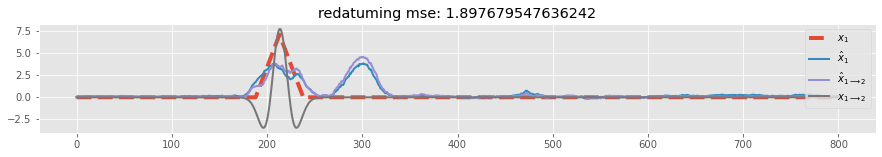

In [28]:
plt.plot(dsyn1[i], label='$x_{1}$', linestyle='dashed', linewidth=4)
plt.plot(dsyn1hat[i], label='$\hat{x}_1$', linewidth=2, )
plt.plot(dsyn21hat[i], label='$\hat{x}_{1\longrightarrow 2}$', linewidth=2  )
plt.plot(dsyn21[i], label='${x}_{1 \longrightarrow 2}$', linewidth=2  )
# plt.plot(dsyn1mixhat[i], label='$\hat{x}_{mix \longrightarrow 1}$', linewidth=2  )
plt.title("redatuming mse: "+ str(mse(dsyn21hat[i], dsyn21[i]).numpy()))
plt.legend()

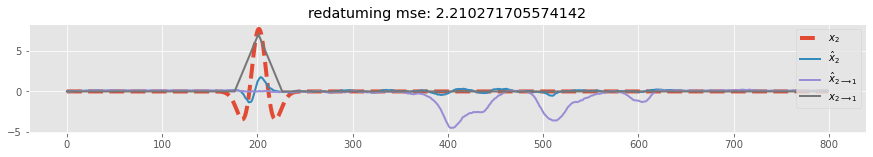

In [29]:
plt.plot(dsyn2[i], label='$x_{2}$', linestyle='dashed', linewidth=4)
plt.plot(dsyn2hat[i], label='$\hat{x}_2$', linewidth=2, )
plt.plot(dsyn12hat[i], label='$\hat{x}_{2\longrightarrow 1}$', linewidth=2  )
plt.plot(dsyn12[i], label='${x}_{2\longrightarrow 1}$', linewidth=2  )
# plt.plot(dsyn2mixhat[i], label='$\hat{x}_{mix\longrightarrow 2}$', linewidth=2  )
plt.title("redatuming mse: "+ str(mse(dsyn12hat[i], dsyn12[i]).numpy()))
plt.legend()

In [ ]:
plt.plot(p1[i], label="nuisance in state 1")
plt.plot(p2[i], label="nuisance in state 2")
plt.plot(dsyn_mix[i], label="nuisance in state 2")
plt.legend()

In [ ]:
plt.plot(dsyn1[i], label='$x_{1}$', linestyle='dashed', linewidth=4)
plt.plot(dsyn1mixhat[i], label='$\hat{x}_1$', linewidth=2, )
plt.plot(dsyn2mixhat[i], label='$\hat{x}_{1\longrightarrow 2}$', linewidth=2  )
# plt.plot(dsyn1mixhat[i], label='$\hat{x}_{mix \longrightarrow 1}$', linewidth=2  )
plt.legend()


In [ ]:
# i=np.random.randint(nsamp)
s1out=[]
for i in range(nsamp):
    ii=np.nonzero(pmix[i])[0][0]
    s1out.append(np.roll(dsyn1mixhat[i], nt//2-ii) / dsyn_mix[i, ii])
s1out=np.mean((np.array(s1out)), axis=0)
s1out[nt//2]=0.0
plt.plot(s1out)


In [ ]:

s2out=[]
for i in range(nsamp):
    ii=np.nonzero(pmix[i])[0][0]
    s2out.append(np.roll(dsyn2mixhat[i], nt//2-ii) / dsyn_mix[i, ii])
s2out=np.mean((np.array(s2out)), axis=0)
s2out[nt//2]=0.0
plt.plot(s2out)

* When we go to state 3; we are supposed 
* States 1 and 2 are the measurements; State 3 is a synthetic state, where we used an impulsive source/
* Redatuming to state 3 means deconvolution --> towards superresolution and resolving
* Assumption are convolutional model. Note that its hard to compress third state. I had to increase q just because of state 3; 

In [ ]:
plt.plot(dsyn_mix[i], label='$x_{mix}$', linestyle='dashed', linewidth=4)
plt.plot(dsynmixhat[i], label='$\hat{x}_{mix}$', linewidth=2, )
plt.legend()

In [ ]:
for i in range(100):
    plt.plot(np.array(model.symencoder(np.array([dsyn1[i:i+1,:],]))).T)

In [ ]:


plt.plot(np.array(model.symencoder(np.array([dsyn1[1:4,:],]))).T)